This notebook shows how to compute the TTS starting from the rawdata. We focus on one of the datasets in `data/ibmq_montreal`, but it should work for any file with the prefix `rawdata`.

Steps to go from rawdata to TTS:
1. rawdata -> rawdf
2. rawdf -> success probabilities,
3. rawdata -> durations
4. durations, sucess probabilities -> tts


# Imports

In [107]:
#allow for autoreload of packages
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [108]:
import pickle
import pandas
from tqdm import tqdm
import matplotlib.pyplot as plt

In [109]:
import rawdata_to_rawdf
import ps_from_rawdf
import circuit_duration_from_calibration_data
import tts_from_rawdf

# Categorize the data by oracle (`rawdata` -> `rawdf`)

In [4]:
machine_long = 'ibmq_montreal' #backend identifier
machine_short = 'montreal'
seq1 = 'ur14'
seq2 = 'supercpmg'
embedding = 2 #logical-to-physical embedding
date = 20220412
rawdata_fname = f"./../data/{machine_long}/{date}/rawdata_{machine_short}_dd-{seq1}-{seq2}_marks-all_embedding-{embedding}.p"
file = open(rawdata_fname, 'rb')
rawdata = pickle.load(file)
file.close()

Structure of `rawdata` files:

`seq_list` : List of sequences used

`data` : raw data from the backend

`calibration_data` : calibration data for the backend, taken on the day of the experiment

`base_circs`: ssBV-n circuits before DD sequences are superimposed

`ancillas`: qubits that were identified as the ancilla

In [5]:
rawdata.keys()

dict_keys(['seq_list', 'data', 'calibration_data', 'base_circs', 'ancillas'])

Below we use the circuit for the oracle $1^{10}$ and identify the marked and ancilla qubits for that circuit.

In [10]:
qc_test = rawdata['base_circs'][10]
rawdata_to_rawdf.bv_identify_ancilla_and_active(qc_test)

[[26, 24, 23, 22, 21, 18, 17, 15, 13, 12], [25]]

Now we can work with the entire dataset and identify the marked and the ancilla for problem sizes. In turn, we return a pandas dataframe with columns 
`free`: ssBV results for the "bare" circuits

sequence 1 : ssBV results under DD sequence 1 

sequence 2 : ssBV results under DD sequence 2 

`ancillas` : qubits treated as ancillas 

`marked` : qubits that are marked

`remaining` : unmarked qubits

Rows correspond to the marked bitstring. 

In [13]:
rawdf = rawdata_to_rawdf.data_to_raw_df(rawdata)

100%|██████████| 27/27 [01:33<00:00,  3.45s/it]


In [14]:
rawdf.keys()

Index(['free', 'ur_14', 'super_cpmg', 'ancillas', 'marked', 'remaining'], dtype='object')

Export `rawdf` for later use.

In [15]:
file = open(rawdata_fname.replace('rawdata', 'rawdf'), 'wb')
rawdf2 = pickle.dump(file)
file.close()

# Success probabilities

We can extract probabilities for BV-n using the information in `rawdf`. 

In [34]:
ps_from_rawdf.restrict_to_bvn(rawdf, ['free','ur_14'], n=3)

,free,ur_14
000,0.920312,0.956250
100,0.722000,0.772531
110,0.734219,0.720219
111,0.465344,0.619938


Create a list of all output distributions like above. 

In [40]:
ps_df_lst = []
for n in tqdm(range(1,27)):
    ps_df_lst.append(ps_from_rawdf.restrict_to_bvn(rawdf, ['free','ur_14'], n=n))

100%|██████████| 26/26 [00:36<00:00,  1.42s/it]


# TTS from success probabilities

We must know both the circuit duration and the success probabilities in order to compute the time to solution. 

## Compute circuit duration

Example: Compute the circuit duration for oracle $1^{10}$.

In [56]:
prop = rawdata['calibration_data']
circuits = rawdata['base_circs']

In [44]:
prop.keys()

dict_keys(['_data', 'backend_name', 'backend_version', 'last_update_date', 'general', 'qubits', 'gates', '_qubits', '_gates'])

In [58]:
qc_test = circuits[10]
circuit_duration_from_calibration_data.circuit_duration(qc_test, prop)

58256

In [61]:
bv_durations = {i: circuit_duration_from_calibration_data.circuit_duration(circuits[i], prop, unit='s') for i in range(len(rawdata['base_circs']))}
bv_durations

{0: 5.2728888888888885e-06,
 1: 5.699555555555556e-06,
 2: 6.069333333333333e-06,
 3: 7.178666666666666e-06,
 4: 8.195555555555556e-06,
 5: 8.600888888888889e-06,
 6: 9.503999999999999e-06,
 7: 1.0442666666666666e-05,
 8: 1.1331555555555554e-05,
 9: 1.2334222222222222e-05,
 10: 1.2945777777777778e-05,
 11: 1.3955555555555555e-05,
 12: 1.4673777777777777e-05,
 13: 1.4944e-05,
 14: 1.5676444444444444e-05,
 15: 1.640888888888889e-05,
 16: 1.7340444444444443e-05,
 17: 1.8229333333333332e-05,
 18: 1.8584888888888887e-05,
 19: 1.9445333333333332e-05,
 20: 2.0284444444444444e-05,
 21: 2.1329777777777776e-05,
 22: 2.2353777777777778e-05,
 23: 2.2915555555555556e-05,
 24: 2.3868444444444442e-05,
 25: 2.4785777777777778e-05,
 26: 2.5340444444444444e-05}

## Compute TTS

Given a dataframe with the sucess probabilities and the time taken to acquire those probabilities we can compute the TTS. By default, tts will be computed in the $log_{10}$ basis.

In [63]:
ps_df_lst[1]

,free,ur_14
00,0.978344,0.985719
10,0.733812,0.786438
11,0.746938,0.726812


In [72]:
tts_from_rawdf.tts_df(ps_df_lst[1], bv_durations)

,free,ur_14
00,-5.198183,-5.242973
10,-4.702655,-4.769512
11,-4.691638,-4.666753


We can then compute the average TTS from the list above.

In [76]:
tts_from_rawdf.tts_average(ps_df_lst[1], bv_durations)

free    -4.823783
ur_14   -4.862187
dtype: float64

Finally we can compute the TTS for all problem sizes.

In [86]:
tts_all = tts_from_rawdf.tts_average_for_all_n(ps_df_lst, bv_durations)

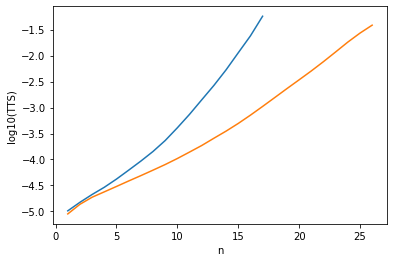

In [91]:
plt.plot(tts_all["free"])
plt.plot(tts_all["ur_14"])
plt.xlabel("n")
plt.ylabel("log10(TTS)")
plt.show()

All the steps above can be combined to a single function.

In [101]:
tts_from_rawdf.tts_from_rawdf(rawdf, bv_durations)

100%|██████████| 26/26 [00:54<00:00,  2.11s/it]


,free,ur_14,super_cpmg
1,-4.988340,-5.047645,-5.067313
2,-4.823783,-4.862187,-4.886111
3,-4.673402,-4.725843,-4.751220
4,-4.534650,-4.622793,-4.641687
5,-4.377012,-4.518849,-4.537293
6,-4.205324,-4.413483,-4.437927
7,-4.030745,-4.310671,-4.339981
8,-3.845332,-4.205025,-4.240593
9,-3.634972,-4.097044,-4.132943
10,-3.389340,-3.980923,-4.017687
